# Gráficos de Cleveland: CO Congruentes vs Incongruentes por Categoría Ideológica

Este notebook genera **gráficos de Cleveland** para visualizar el Cambio de Opinión (CO) comparando respuestas **congruentes** e **incongruentes** con la ideología, agrupadas por **categoría ideológica**.

## Concepto:

### Congruencia Ideológica:
- **CO_Congruente**: Ítems Progresistas → Izquierda + Ítems Conservadores → Derecha
- **CO_Incongruente**: Ítems Progresistas → Derecha + Ítems Conservadores → Izquierda

### Visualización:
- **Punto azul (●)**: CO Congruente (ideológicamente consistente)
- **Punto rojo (●)**: CO Incongruente (ideológicamente inconsistente)
- **Línea conectando**: Muestra la diferencia
- **Color de línea**:
  - Verde: Mayor CO en Incongruentes (>0.1)
  - Gris: Similar (±0.1)
  - Naranja: Mayor CO en Congruentes (<-0.1)

## Interpretación:

- **Valores positivos**: Mayor cambio de opinión
- **Hipótesis**: Se espera mayor CO en ítems incongruentes (conflicto ideológico genera más cambios)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.lines import Line2D
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✓ Librerías cargadas exitosamente')

✓ Librerías cargadas exitosamente


## 1. Cargar Datos

In [2]:
# Rutas a los archivos
Ruta_Base = os.path.join(os.getcwd(), '..', 'Data', 'Procesados')
Archivo_Generales = os.path.join(Ruta_Base, 'Generales_con_Congruencia.xlsx')
Archivo_Ballotage = os.path.join(Ruta_Base, 'Ballotage_con_Congruencia.xlsx')

# Cargar datos
df_Generales = pd.read_excel(Archivo_Generales)
df_Ballotage = pd.read_excel(Archivo_Ballotage)

dfs = {
    'Generales': df_Generales,
    'Ballotage': df_Ballotage
}

print(f'✓ Datos cargados:')
print(f'  - Generales: {len(df_Generales)} registros')
print(f'  - Ballotage: {len(df_Ballotage)} registros')

# Verificar variables
vars_necesarias = ['CO_Congruente', 'CO_Incongruente', 'Categoria_PASO_2023']
for nombre, df in dfs.items():
    faltantes = [v for v in vars_necesarias if v not in df.columns]
    if faltantes:
        print(f'  ⚠️  {nombre}: Faltan variables {faltantes}')
    else:
        print(f'  ✅ {nombre}: Todas las variables presentes')

✓ Datos cargados:
  - Generales: 2786 registros
  - Ballotage: 1254 registros
  ✅ Generales: Todas las variables presentes
  ✅ Ballotage: Todas las variables presentes


## 2. Preparar Datos para Gráfico

In [3]:
# Definir categorías ideológicas
Categorias = [
    'Left_Wing',
    'Progressivism',
    'Centre',
    'Moderate_Right_A',
    'Moderate_Right_B',
    'Right_Wing_Libertarian'
]

Etiquetas_Categorias = {
    'Left_Wing': 'Left Wing',
    'Progressivism': 'Progressivism',
    'Centre': 'Centre',
    'Moderate_Right_A': 'Moderate Right A',
    'Moderate_Right_B': 'Moderate Right B',
    'Right_Wing_Libertarian': 'Right Wing Libertarian'
}

print(f'Categorías ideológicas: {len(Categorias)}')
for cat in Categorias:
    print(f'  - {Etiquetas_Categorias[cat]}')

Categorías ideológicas: 6
  - Left Wing
  - Progressivism
  - Centre
  - Moderate Right A
  - Moderate Right B
  - Right Wing Libertarian


In [4]:
# Calcular promedios por categoría para cada dataset
def Preparar_Datos_Por_Categoria(df, categorias):
    """
    Calcula promedios de CO_Congruente e Incongruente por categoría.
    Incluye test de Wilcoxon pareado para significancia estadística.
    """
    datos = []
    
    for categoria in categorias:
        df_cat = df[df['Categoria_PASO_2023'] == categoria]
        
        if len(df_cat) > 0:
            media_cong = df_cat['CO_Congruente'].mean()
            media_incong = df_cat['CO_Incongruente'].mean()
            diferencia = media_incong - media_cong
            
            # Test de Wilcoxon pareado para significancia
            datos_pareados = df_cat[['CO_Congruente', 'CO_Incongruente']].dropna()
            if len(datos_pareados) > 1:
                from scipy.stats import wilcoxon
                try:
                    stat, p_valor = wilcoxon(datos_pareados['CO_Incongruente'], 
                                             datos_pareados['CO_Congruente'])
                    
                    # Determinar asteriscos de significancia
                    if p_valor < 0.001:
                        sig = '***'
                    elif p_valor < 0.01:
                        sig = '**'
                    elif p_valor < 0.05:
                        sig = '*'
                    else:
                        sig = ''
                except:
                    p_valor = np.nan
                    sig = ''
            else:
                p_valor = np.nan
                sig = ''
            
            datos.append({
                'Categoria': categoria,
                'Etiqueta': Etiquetas_Categorias[categoria],
                'n': len(df_cat),
                'CO_Congruente': media_cong,
                'CO_Incongruente': media_incong,
                'Diferencia': diferencia,
                'p_valor': p_valor,
                'Significancia': sig
            })
    
    return pd.DataFrame(datos)

# Preparar datos para ambos datasets
datos_graficos = {}
for nombre, df in dfs.items():
    datos_graficos[nombre] = Preparar_Datos_Por_Categoria(df, Categorias)
    print(f'\n{nombre}:')
    print(datos_graficos[nombre][['Etiqueta', 'n', 'CO_Congruente', 'CO_Incongruente', 'Diferencia', 'Significancia']])


Generales:
                 Etiqueta     n  CO_Congruente  CO_Incongruente  Diferencia  \
0               Left Wing   425       0.854118        -0.752941   -1.607059   
1           Progressivism  1257       0.966587        -0.776452   -1.743039   
2                  Centre    84       0.172619        -0.494048   -0.666667   
3        Moderate Right A   208       0.725962        -0.389423   -1.115385   
4        Moderate Right B   212       0.806604        -0.292453   -1.099057   
5  Right Wing Libertarian   185       0.556757        -0.616216   -1.172973   

  Significancia  
0           ***  
1           ***  
2                
3             *  
4             *  
5            **  

Ballotage:
                 Etiqueta    n  CO_Congruente  CO_Incongruente  Diferencia  \
0               Left Wing  133       0.022556        -0.578947   -0.601504   
1           Progressivism  597       0.512563        -0.169179   -0.681742   
2                  Centre   43       1.325581         0.453488

## 3. Función para Crear Gráfico de Cleveland

In [5]:
def Crear_Grafico_Cleveland_CO_Categorias(df, titulo, nombre_archivo=None, carpeta_destino='Graficos_Cleveland'):
    """
    Crea un gráfico de Cleveland mostrando CO Congruente vs Incongruente por categoría.
    Incluye asteriscos para indicar significancia estadística.
    """
    
    # Crear carpeta si no existe
    if not os.path.exists(carpeta_destino):
        os.makedirs(carpeta_destino)
    
    # Ordenar por diferencia (descendente)
    df_sorted = df.sort_values('Diferencia', ascending=True).reset_index(drop=True)
    
    # Crear figura
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Parámetros visuales
    y_positions = np.arange(len(df_sorted))
    
    # Dibujar líneas conectando los puntos
    for idx, row in df_sorted.iterrows():
        cong_val = row['CO_Congruente']
        incong_val = row['CO_Incongruente']
        diferencia = row['Diferencia']
        
        # Determinar color de línea según diferencia
        if diferencia > 0.1:  # Más CO en Incongruentes
            color_linea = '#2ecc71'  # Verde
            alpha = 0.7
        elif diferencia < -0.1:  # Más CO en Congruentes
            color_linea = '#e74c3c'  # Rojo/Naranja
            alpha = 0.7
        else:  # Diferencia pequeña
            color_linea = '#95a5a6'  # Gris
            alpha = 0.4
        
        # Dibujar línea
        ax.plot([cong_val, incong_val], [idx, idx], 
                color=color_linea, linewidth=2, alpha=alpha, zorder=1)
    
    # Dibujar puntos de Congruente
    ax.scatter(df_sorted['CO_Congruente'], y_positions, 
               s=150, c='#3498db', marker='o', 
               edgecolors='white', linewidths=2,
               label='Congruente', zorder=3, alpha=0.9)
    
    # Dibujar puntos de Incongruente
    ax.scatter(df_sorted['CO_Incongruente'], y_positions, 
               s=150, c='#e74c3c', marker='o', 
               edgecolors='white', linewidths=2,
               label='Incongruente', zorder=3, alpha=0.9)
    
    # Línea vertical en x=0
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8, alpha=0.3, zorder=0)
    
    # Configurar ejes con asteriscos de significancia
    ax.set_yticks(y_positions)
    etiquetas_con_sig = [f"{row['Etiqueta']} {row['Significancia']}" if row['Significancia'] else row['Etiqueta'] 
                         for _, row in df_sorted.iterrows()]
    ax.set_yticklabels(etiquetas_con_sig, fontsize=11)
    
    ax.set_xlabel('Cambio de Opinión (promedio)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Categoría Ideológica', fontsize=12, fontweight='bold')
    ax.set_title(titulo, fontsize=14, fontweight='bold', pad=20)
    
    # Grid
    ax.grid(True, axis='x', alpha=0.3, linestyle=':', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Leyenda personalizada
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db', 
               markersize=11, label='Congruente', markeredgecolor='white', markeredgewidth=1.5),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', 
               markersize=11, label='Incongruente', markeredgecolor='white', markeredgewidth=1.5),
        Line2D([0], [0], color='#2ecc71', linewidth=2.5, label='Mayor Incong (>0.1)'),
        Line2D([0], [0], color='#95a5a6', linewidth=2.5, label='Similar (±0.1)'),
        Line2D([0], [0], color='#e74c3c', linewidth=2.5, label='Mayor Cong (<-0.1)'),
        Line2D([0], [0], marker='', color='w', label='* p<0.05, ** p<0.01, *** p<0.001')
    ]
    
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10, 
              framealpha=0.95, edgecolor='gray')
    
    # Ajustar layout
    plt.tight_layout()
    
    # Guardar
    if nombre_archivo:
        ruta_completa = os.path.join(carpeta_destino, f'{nombre_archivo}.png')
        plt.savefig(ruta_completa, dpi=300, bbox_inches='tight', facecolor='white')
        print(f'✅ Gráfico guardado: {ruta_completa}')
    
    plt.show()
    
    return fig, ax

## 4. Gráficos por Dataset

Generando gráfico para Generales...

✅ Gráfico guardado: Graficos_Cleveland\Cleveland_CO_Congruente_vs_Incongruente_Generales.png


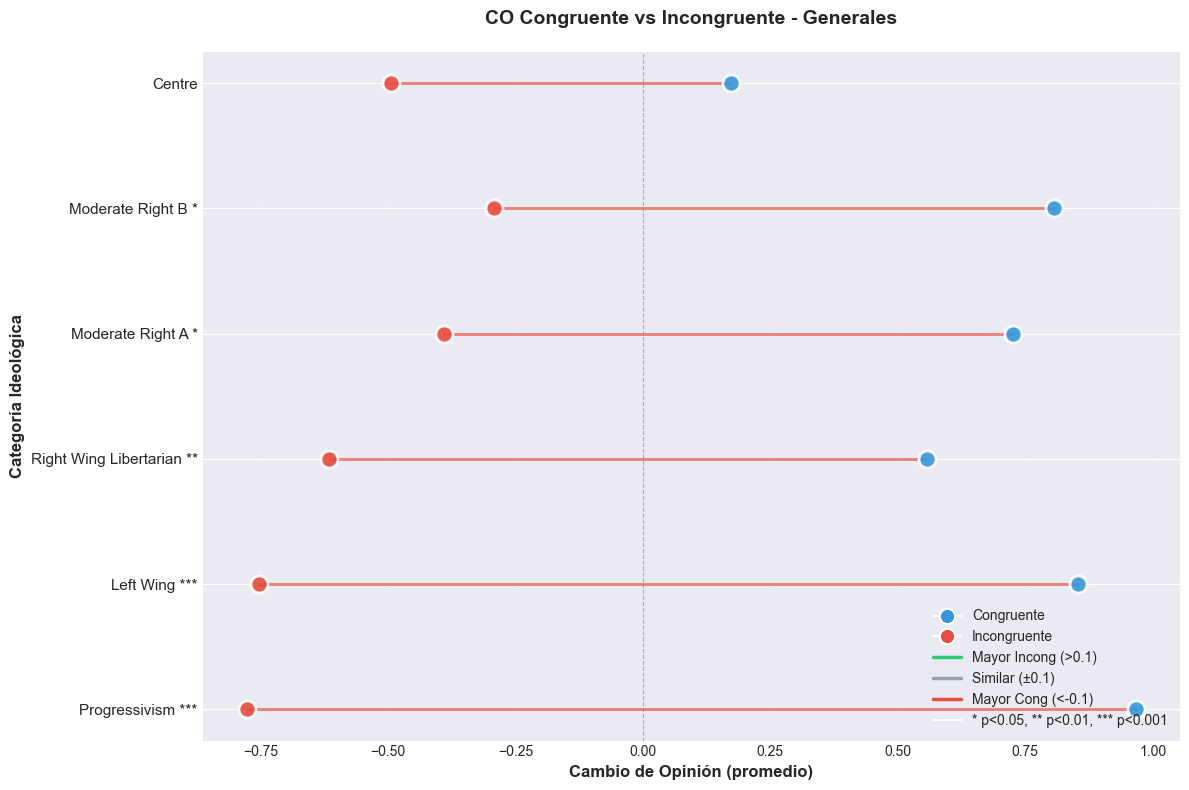

In [6]:
# Crear gráfico para Generales
print('Generando gráfico para Generales...\n')
fig_gen, ax_gen = Crear_Grafico_Cleveland_CO_Categorias(
    datos_graficos['Generales'],
    titulo='CO Congruente vs Incongruente - Generales',
    nombre_archivo='Cleveland_CO_Congruente_vs_Incongruente_Generales'
)

Generando gráfico para Ballotage...

✅ Gráfico guardado: Graficos_Cleveland\Cleveland_CO_Congruente_vs_Incongruente_Ballotage.png


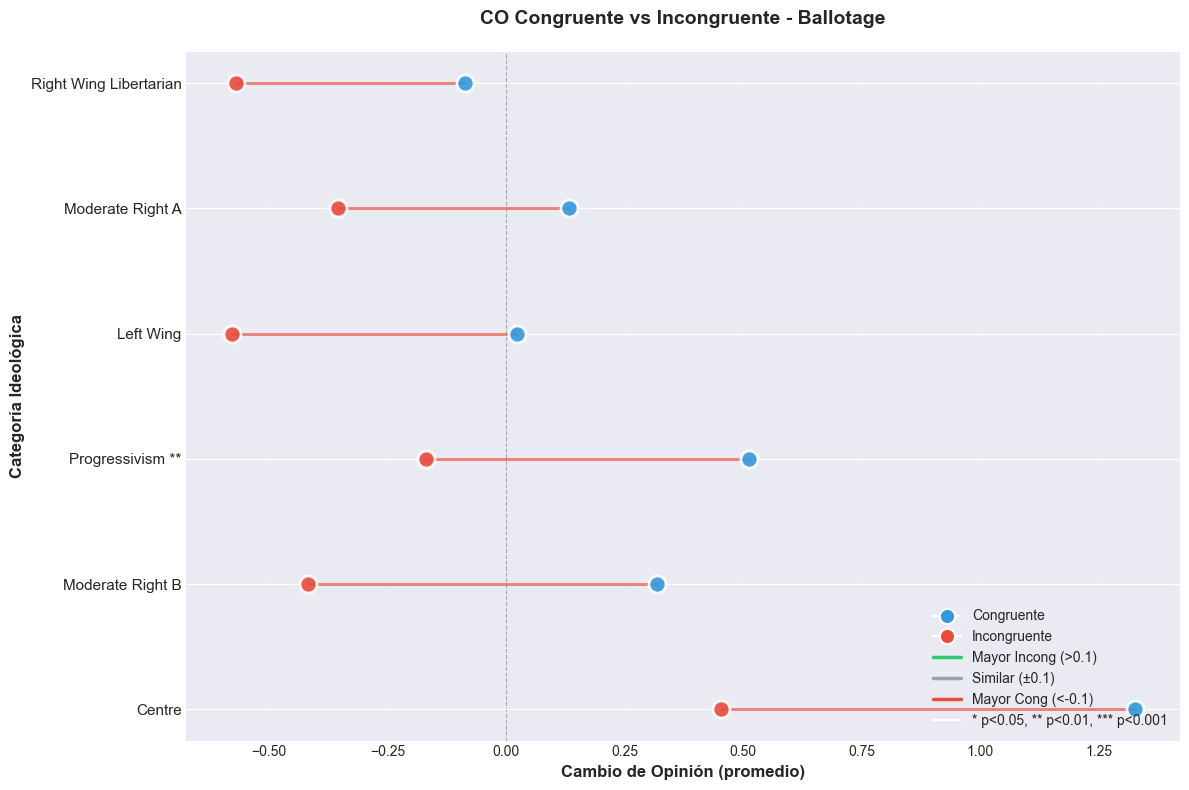

In [7]:
# Crear gráfico para Ballotage
print('Generando gráfico para Ballotage...\n')
fig_bal, ax_bal = Crear_Grafico_Cleveland_CO_Categorias(
    datos_graficos['Ballotage'],
    titulo='CO Congruente vs Incongruente - Ballotage',
    nombre_archivo='Cleveland_CO_Congruente_vs_Incongruente_Ballotage'
)

## 4.1. Análisis de Significancia Estadística

In [8]:
print('='*70)
print('ANÁLISIS DE SIGNIFICANCIA ESTADÍSTICA')
print('Test de Wilcoxon Pareado: CO Congruente vs Incongruente')
print('='*70)

for nombre, df_datos in datos_graficos.items():
    print(f'\n📊 {nombre}:')
    print('-'*70)
    
    # Filtrar categorías con significancia
    sig_categorias = df_datos[df_datos['Significancia'] != ''].copy()
    
    if len(sig_categorias) > 0:
        print(f'\n✅ Categorías con diferencias significativas: {len(sig_categorias)}')
        print('\nDetalle:')
        for _, row in sig_categorias.iterrows():
            direccion = 'Incong > Cong' if row['Diferencia'] > 0 else 'Cong > Incong'
            print(f"  {row['Significancia']:3s} {row['Etiqueta']:25s} | Dif: {row['Diferencia']:6.3f} | p={row['p_valor']:.4f} | {direccion}")
    else:
        print('\n❌ No hay categorías con diferencias significativas (p < 0.05)')
    
    # Categorías no significativas
    no_sig = df_datos[df_datos['Significancia'] == '']
    if len(no_sig) > 0:
        print(f'\n⚪ Categorías sin diferencias significativas: {len(no_sig)}')
        for _, row in no_sig.iterrows():
            if not pd.isna(row['p_valor']):
                print(f"      {row['Etiqueta']:25s} | Dif: {row['Diferencia']:6.3f} | p={row['p_valor']:.4f}")
    
    print('\n' + '-'*70)

print('\n' + '='*70)
print('Niveles de significancia: * p<0.05, ** p<0.01, *** p<0.001')
print('='*70)

ANÁLISIS DE SIGNIFICANCIA ESTADÍSTICA
Test de Wilcoxon Pareado: CO Congruente vs Incongruente

📊 Generales:
----------------------------------------------------------------------

✅ Categorías con diferencias significativas: 5

Detalle:
  *** Left Wing                 | Dif: -1.607 | p=0.0000 | Cong > Incong
  *** Progressivism             | Dif: -1.743 | p=0.0000 | Cong > Incong
  *   Moderate Right A          | Dif: -1.115 | p=0.0174 | Cong > Incong
  *   Moderate Right B          | Dif: -1.099 | p=0.0102 | Cong > Incong
  **  Right Wing Libertarian    | Dif: -1.173 | p=0.0023 | Cong > Incong

⚪ Categorías sin diferencias significativas: 1
      Centre                    | Dif: -0.667 | p=0.6678

----------------------------------------------------------------------

📊 Ballotage:
----------------------------------------------------------------------

✅ Categorías con diferencias significativas: 1

Detalle:
  **  Progressivism             | Dif: -0.682 | p=0.0095 | Cong > Incong

⚪ Ca

## 5. Análisis Estadístico

In [9]:
print('='*70)
print('ANÁLISIS ESTADÍSTICO: CO CONGRUENTE VS INCONGRUENTE')
print('='*70)

for nombre, df_datos in datos_graficos.items():
    print(f'\n📊 {nombre}:')
    print('-'*70)
    
    print(f'\nEstadísticas Generales:')
    print(f'  Promedio CO_Congruente: {df_datos["CO_Congruente"].mean():.4f}')
    print(f'  Promedio CO_Incongruente: {df_datos["CO_Incongruente"].mean():.4f}')
    print(f'  Diferencia promedio: {df_datos["Diferencia"].mean():.4f}')
    
    # Distribución
    mayor_incong = len(df_datos[df_datos['Diferencia'] > 0.1])
    similares = len(df_datos[(df_datos['Diferencia'] >= -0.1) & (df_datos['Diferencia'] <= 0.1)])
    mayor_cong = len(df_datos[df_datos['Diferencia'] < -0.1])
    
    print(f'\nDistribución:')
    print(f'  Mayor en Incongruentes: {mayor_incong} categorías')
    print(f'  Similar: {similares} categorías')
    print(f'  Mayor en Congruentes: {mayor_cong} categorías')
    
    # Test t pareado
    t_stat, p_value = stats.ttest_rel(df_datos['CO_Incongruente'], df_datos['CO_Congruente'])
    
    print(f'\nTest t Pareado:')
    print(f'  Estadístico t: {t_stat:.4f}')
    print(f'  Valor p: {p_value:.4f}')
    
    if p_value < 0.05:
        print(f'  ✅ SIGNIFICATIVO (p < 0.05)')
        if df_datos['Diferencia'].mean() > 0:
            print(f'     Mayor CO en Incongruentes')
        else:
            print(f'     Mayor CO en Congruentes')
    else:
        print(f'  ❌ NO SIGNIFICATIVO (p ≥ 0.05)')
    
    print('\n' + '-'*70)

print('\n' + '='*70)

ANÁLISIS ESTADÍSTICO: CO CONGRUENTE VS INCONGRUENTE

📊 Generales:
----------------------------------------------------------------------

Estadísticas Generales:
  Promedio CO_Congruente: 0.6804
  Promedio CO_Incongruente: -0.5536
  Diferencia promedio: -1.2340

Distribución:
  Mayor en Incongruentes: 0 categorías
  Similar: 0 categorías
  Mayor en Congruentes: 6 categorías

Test t Pareado:
  Estadístico t: -7.7728
  Valor p: 0.0006
  ✅ SIGNIFICATIVO (p < 0.05)
     Mayor CO en Congruentes

----------------------------------------------------------------------

📊 Ballotage:
----------------------------------------------------------------------

Estadísticas Generales:
  Promedio CO_Congruente: 0.3712
  Promedio CO_Incongruente: -0.2730
  Diferencia promedio: -0.6442

Distribución:
  Mayor en Incongruentes: 0 categorías
  Similar: 0 categorías
  Mayor en Congruentes: 6 categorías

Test t Pareado:
  Estadístico t: -10.4677
  Valor p: 0.0001
  ✅ SIGNIFICATIVO (p < 0.05)
     Mayor CO en C

## 6. Categorías con Mayor Diferencia

In [10]:
print('='*70)
print('CATEGORÍAS CON MAYOR DIFERENCIA')
print('='*70)

for nombre, df_datos in datos_graficos.items():
    print(f'\n📊 {nombre}:')
    print('-'*70)
    
    print(f'\nMayor diferencia (Incong > Cong):')
    top_incong = df_datos.nlargest(3, 'Diferencia')[['Etiqueta', 'CO_Congruente', 'CO_Incongruente', 'Diferencia']]
    print(top_incong.to_string(index=False))
    
    print(f'\nMayor diferencia (Cong > Incong):')
    top_cong = df_datos.nsmallest(3, 'Diferencia')[['Etiqueta', 'CO_Congruente', 'CO_Incongruente', 'Diferencia']]
    print(top_cong.to_string(index=False))
    
    print('\n' + '-'*70)

print('\n' + '='*70)

CATEGORÍAS CON MAYOR DIFERENCIA

📊 Generales:
----------------------------------------------------------------------

Mayor diferencia (Incong > Cong):
        Etiqueta  CO_Congruente  CO_Incongruente  Diferencia
          Centre       0.172619        -0.494048   -0.666667
Moderate Right B       0.806604        -0.292453   -1.099057
Moderate Right A       0.725962        -0.389423   -1.115385

Mayor diferencia (Cong > Incong):
              Etiqueta  CO_Congruente  CO_Incongruente  Diferencia
         Progressivism       0.966587        -0.776452   -1.743039
             Left Wing       0.854118        -0.752941   -1.607059
Right Wing Libertarian       0.556757        -0.616216   -1.172973

----------------------------------------------------------------------

📊 Ballotage:
----------------------------------------------------------------------

Mayor diferencia (Incong > Cong):
              Etiqueta  CO_Congruente  CO_Incongruente  Diferencia
Right Wing Libertarian      -0.086022     

## 7. Guardar Tablas Resumen

In [11]:
# Crear carpeta de salida
Carpeta_Salida = os.path.join(os.getcwd(), '..', 'Data', 'Resultados_Cleveland')
if not os.path.exists(Carpeta_Salida):
    os.makedirs(Carpeta_Salida)

# Guardar tablas
for nombre, df_datos in datos_graficos.items():
    archivo = os.path.join(Carpeta_Salida, f'Resumen_CO_Congruente_vs_Incongruente_{nombre}.xlsx')
    df_datos.to_excel(archivo, index=False)
    print(f'✅ Guardado: {archivo}')

✅ Guardado: c:\Users\Patricio\Documents\Codigo\Python\Investigacion\Tesis\Código\..\Data\Resultados_Cleveland\Resumen_CO_Congruente_vs_Incongruente_Generales.xlsx
✅ Guardado: c:\Users\Patricio\Documents\Codigo\Python\Investigacion\Tesis\Código\..\Data\Resultados_Cleveland\Resumen_CO_Congruente_vs_Incongruente_Ballotage.xlsx


## 8. Resumen Final

In [12]:
print('='*70)
print('RESUMEN: CO CONGRUENTE VS INCONGRUENTE POR CATEGORÍA')
print('='*70)

print('\n📊 Análisis completado:')
print(f'  - Datasets analizados: 2 (Generales y Ballotage)')
print(f'  - Categorías por dataset: {len(Categorias)}')
print(f'  - Gráficos generados: 2 (Cleveland plots)')

print('\n📁 Archivos generados:')
print('  - Cleveland_CO_Congruente_vs_Incongruente_Generales.png')
print('  - Cleveland_CO_Congruente_vs_Incongruente_Ballotage.png')
print('  - Resumen_CO_Congruente_vs_Incongruente_Generales.xlsx')
print('  - Resumen_CO_Congruente_vs_Incongruente_Ballotage.xlsx')

print('\n💡 Interpretación:')
print('  - CO_Congruente: Cambios ideológicamente consistentes')
print('  - CO_Incongruente: Cambios ideológicamente inconsistentes')
print('  - Hipótesis: Mayor CO en incongruentes (conflicto ideológico)')

print('\n' + '='*70)
print('✅ ANÁLISIS COMPLETADO')
print('='*70)

RESUMEN: CO CONGRUENTE VS INCONGRUENTE POR CATEGORÍA

📊 Análisis completado:
  - Datasets analizados: 2 (Generales y Ballotage)
  - Categorías por dataset: 6
  - Gráficos generados: 2 (Cleveland plots)

📁 Archivos generados:
  - Cleveland_CO_Congruente_vs_Incongruente_Generales.png
  - Cleveland_CO_Congruente_vs_Incongruente_Ballotage.png
  - Resumen_CO_Congruente_vs_Incongruente_Generales.xlsx
  - Resumen_CO_Congruente_vs_Incongruente_Ballotage.xlsx

💡 Interpretación:
  - CO_Congruente: Cambios ideológicamente consistentes
  - CO_Incongruente: Cambios ideológicamente inconsistentes
  - Hipótesis: Mayor CO en incongruentes (conflicto ideológico)

✅ ANÁLISIS COMPLETADO
